In [1]:
import tensorflow as tf
import pandas as pd

导入数据

In [2]:
data_txt_train = pd.read_csv(r'.\data\train.csv')
data_txt_test = pd.read_csv(r'.\data\test.csv')
data_txt_labels = pd.read_csv(r'.\data\sample_submission.csv')

从数据中挑出那些有用的数据，这里为了简单起见，我们只考虑text和target。

In [3]:
x_train = data_txt_train['text']
y_train = data_txt_train['target']
x_test = data_txt_test['text']
y_test = data_txt_labels['target']

因为之后要做tokenize（词元化），将词与index对应起来，得到一个{word：index}的字典
所以我们需要将train_data和test_data拼接起来

In [4]:
train_data = pd.concat([x_train, y_train], axis=1)
test_data = pd.concat([x_test, y_test], axis=1)
data = pd.concat([train_data, test_data])
print(train_data.shape, test_data.shape, data.shape)

(7613, 2) (3263, 2) (10876, 2)


# 词元化

设置字典的大小，每个样本的最大单词

In [5]:
max_words = 10000
sen_words_max_len = 100

掉用tf.keras.preprocessing.text.Tokenizer

In [6]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_words)

In [7]:
tokenizer.fit_on_texts(data.iloc[:,0])
words_indexes = tokenizer.word_index

In [8]:
len(words_indexes)

29319

In [9]:
sequence = tokenizer.texts_to_sequences(data.iloc[:,0])

sequence就是RaggedTensor（稀疏张量）,再调用tf.keras.preprocessing.sequence.pad_sequences命令将其填充成正常的Tensor

In [10]:
data_pad = tf.keras.preprocessing.sequence.pad_sequences(sequence,maxlen=sen_words_max_len)

In [11]:
x = tf.convert_to_tensor(data_pad)
y = tf.convert_to_tensor(data.iloc[:,1].values)

In [12]:
lenth = len(data.iloc[:,0])
lenth

10876

再将合并起来的数据，拆成训练数据与验证数据

In [13]:
index = tf.range(lenth)
index = tf.random.shuffle(index)
x_train = tf.gather(x, index[:7000])
y_train = tf.gather(y, index[:7000])
x_test = tf.gather(x, index[7000:])
y_test = tf.gather(y, index[7000:])

# 数据集

再将数据打包成数据集

In [14]:
ds_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
ds_test = tf.data.Dataset.from_tensor_slices((x_test, y_test))
print(ds_train, ds_test)

<TensorSliceDataset shapes: ((100,), ()), types: (tf.int32, tf.int64)> <TensorSliceDataset shapes: ((100,), ()), types: (tf.int32, tf.int64)>


写一个预处理函数，用来把数据转换到int32

In [15]:
def preprocessing(x, y):
    x = tf.cast(x, dtype=tf.int32)
    y = tf.cast(y, dtype=tf.int32)
    return x, y

把数据按预处理函数map一下，在取batch。这个.prefetch(tf.data.experimental.AUTOTUNE)，是看看能不能用几张卡来并行跑模型

In [16]:
batch_size = 128
ds_train = ds_train.map(preprocessing).batch(batch_size, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)
ds_test = ds_test.map(preprocessing).batch(batch_size, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)
print(ds_train, ds_test)

<PrefetchDataset shapes: ((128, 100), (128,)), types: (tf.int32, tf.int32)> <PrefetchDataset shapes: ((128, 100), (128,)), types: (tf.int32, tf.int32)>


# 定义模型

写一个简单的RNN，这里使用他的cell，所以需要在[b, t, v]中的dim = 1也就是时间步t上展开，使用for遍历

In [17]:
class Net(tf.keras.Model):
    def __init__(self,input_dim=max_words, output_dim=16,
                 input_length=sen_words_max_len, units=64):
        super(Net, self).__init__()
        self.state0 = tf.zeros([batch_size, units])
        self.embedding = tf.keras.layers.Embedding(input_dim, output_dim,
                                                   input_length=input_length)
        self.rnn_cell0 = tf.keras.layers.SimpleRNNCell(units, dropout=0.8)
        self.fc = tf.keras.layers.Dense(1)
    
    def call(self, inputs, training=None):
        """
        net(x)&net(x, training=True) is training mode
        """
        x = self.embedding(inputs)
        state0 = self.state0
        for word in tf.unstack(x, axis=1):
            out, state1 = self.rnn_cell0(word, state0)
            state0 = state1
        logit = self.fc(out)
        prob = tf.sigmoid(logit)
        return logit
            
        

# 编辑模型并训练

In [19]:

model = Net()
epochs = 50
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
             loss=tf.losses.BinaryCrossentropy(),
             metrics=['accuracy'])
history=model.fit(ds_train, epochs=epochs, 
          validation_data=ds_test, validation_steps=10)


Epoch 1/50
54/54 [==============================] - 2s 29ms/step - loss: 1.6507 - accuracy: 0.6852 - val_loss: 0.6310 - val_accuracy: 0.6852
Epoch 2/50
54/54 [==============================] - 1s 13ms/step - loss: 0.9679 - accuracy: 0.6373 - val_loss: 0.6277 - val_accuracy: 0.6883
Epoch 3/50
54/54 [==============================] - 1s 13ms/step - loss: 0.8487 - accuracy: 0.6701 - val_loss: 0.6221 - val_accuracy: 0.6945
Epoch 4/50
54/54 [==============================] - 1s 13ms/step - loss: 0.6905 - accuracy: 0.6597 - val_loss: 0.6178 - val_accuracy: 0.6945
Epoch 5/50
54/54 [==============================] - 1s 12ms/step - loss: 0.6604 - accuracy: 0.6729 - val_loss: 0.6141 - val_accuracy: 0.6961
Epoch 6/50
54/54 [==============================] - 1s 13ms/step - loss: 0.6362 - accuracy: 0.6816 - val_loss: 0.6106 - val_accuracy: 0.6961
Epoch 7/50
54/54 [==============================] - 1s 13ms/step - loss: 0.6349 - accuracy: 0.6913 - val_loss: 0.6085 - val_accuracy: 0.6961
Epoch 8/50
54

# 评估模型

由于这里我们只将数据拆成两份，所以其实这里的验证集与测试集混着用了

In [20]:
test_loss, test_acc = model.evaluate(ds_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

30/30 [==============================] - 0s 7ms/step - loss: 0.6038 - accuracy: 0.7109
Test Loss: 0.603756844997406
Test Accuracy: 0.7109375


# 将结果用图表示出来

In [21]:
import matplotlib.pyplot as plt
def plot_graph(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.show()

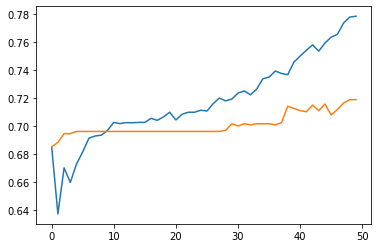

In [22]:
plot_graph(history, 'accuracy')

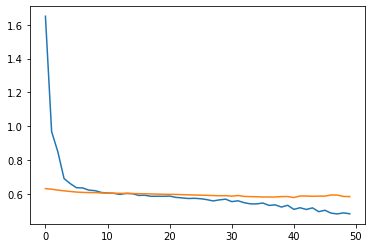

In [23]:
plot_graph(history, 'loss')